### Sampling records from the pre-saved datasets

##### Using seen(train) data on MLP with one hidden layer

In [76]:
import torch
import joblib
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 1) Load the pretrained model
model = torch.jit.load(r'Models and Data splits/MainModel_MLP1L.pt')
model.to(device)
model.eval()

# 2) Load the original [0,255] train/test splits
data_path = "Models and Data splits/[ORIGINAL] Train_Test_Splits.pkl"
X_train, X_test, y_train, y_test = joblib.load(data_path)

sampled_X = []
sampled_y = []

for digit in range(10):
    # a) all train samples of this true digit (still in [0,255])
    idx = np.where(y_train == digit)[0]
    X_d = X_train[idx]    # shape (N_d, features), values 0–255
    y_d = y_train[idx]

    # b) temporarily scale to [0,1] for the network
    Xd_scaled = X_d / 255.0
    Xd_tensor = torch.tensor(Xd_scaled, dtype=torch.float32).to(device)

    # c) run inference
    with torch.no_grad():
        out = model(Xd_tensor)
        _, preds = torch.max(out, dim=1)
        preds_np = preds.cpu().numpy()

    # d) keep only correctly predicted indices
    correct_local = np.where(preds_np == digit)[0]
    if len(correct_local) < 50:
        raise ValueError(f"Digit {digit} only has {len(correct_local)} correctly classified samples; need 50.")

    # e) randomly pick 50 correct ones (still using original X_d)
    choose = np.random.choice(correct_local, 50, replace=False)
    sampled_X.append(X_d[choose])
    sampled_y.append(y_d[choose])

# 3) stack into (500, …) arrays
sampled_X = np.vstack(sampled_X)  # values remain in [0,255]
sampled_y = np.hstack(sampled_y)

# 4) save only the ORIGINAL‐scale data and labels, same filename
output_path = "Models and Data splits/MLP1L_500_samples_train.pkl"
joblib.dump([sampled_X, sampled_y], output_path)

print(f"Saved 500 correctly classified samples from the train set (50 per digit) to {output_path}")


Saved 500 correctly classified samples from the train set (50 per digit) to Models and Data splits/MLP1L_500_samples_train.pkl


##### Using unseen(test) data on MLP with one hidden layer

In [78]:
import torch
import joblib
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 1) Load the pretrained model
model = torch.jit.load(r'Models and Data splits/MainModel_MLP1L.pt')
model.to(device)
model.eval()

# 2) Load the original [0,255] train/test splits
data_path = "Models and Data splits/[ORIGINAL] Train_Test_Splits.pkl"
X_train, X_test, y_train, y_test = joblib.load(data_path)

sampled_X = []
sampled_y = []

for digit in range(10):
    # a) all test samples of this true digit (still in [0,255])
    idx = np.where(y_test == digit)[0]
    X_d = X_test[idx]    # shape (N_d, features), values 0–255
    y_d = y_test[idx]

    # b) temporarily scale to [0,1] for the network
    Xd_scaled = X_d / 255.0
    Xd_tensor = torch.tensor(Xd_scaled, dtype=torch.float32).to(device)

    # c) run inference
    with torch.no_grad():
        out = model(Xd_tensor)
        _, preds = torch.max(out, dim=1)
        preds_np = preds.cpu().numpy()

    # d) keep only correctly predicted indices
    correct_local = np.where(preds_np == digit)[0]
    if len(correct_local) < 50:
        raise ValueError(f"Digit {digit} only has {len(correct_local)} correctly classified samples; need 50.")

    # e) randomly pick 50 correct ones (still using original X_d)
    choose = np.random.choice(correct_local, 50, replace=False)
    sampled_X.append(X_d[choose])
    sampled_y.append(y_d[choose])

# 3) stack into (500, …) arrays
sampled_X = np.vstack(sampled_X)  # values remain in [0,255]
sampled_y = np.hstack(sampled_y)

# 4) save only the ORIGINAL‐scale data and labels, same filename
output_path = "Models and Data splits/MLP1L_500_samples_test.pkl"
joblib.dump([sampled_X, sampled_y], output_path)

print(f"Saved 500 correctly classified samples from the train set (50 per digit) to {output_path}")


Saved 500 correctly classified samples from the train set (50 per digit) to Models and Data splits/MLP1L_500_samples_test.pkl


### Using CNN on unseen/test data

In [80]:
import torch
import joblib
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 1) Load the pretrained CNN (replace with your CNN .pt if needed)
model = torch.jit.load(r'Models and Data splits/CNN.pt')
model.to(device)
model.eval()

# 2) Load the original [0,255] train/test splits
data_path = "Models and Data splits/[ORIGINAL] Train_Test_Splits.pkl"
X_train, X_test, y_train, y_test = joblib.load(data_path)

# Figure out image size (assumes square, grayscale images)
num_features = X_train.shape[1]
side = int(np.sqrt(num_features))
assert side * side == num_features, f"Expected square images, got {num_features} features."

sampled_X = []
sampled_y = []

for digit in range(10):
    # a) get all test samples of this true digit (still in [0,255])
    idx = np.where(y_test == digit)[0]
    X_d = X_test[idx]    # shape (N_d, num_features)
    y_d = y_test[idx]    # shape (N_d,)

    # b) reshape + scale to [0,1] for the CNN: (N_d, 1, side, side)
    Xd_scaled = (X_d.astype(np.float32) / 255.0).reshape(-1, 1, side, side)
    Xd_tensor = torch.from_numpy(Xd_scaled).to(device)

    # c) inference
    with torch.no_grad():
        out = model(Xd_tensor)
        _, preds = torch.max(out, dim=1)
        preds_np = preds.cpu().numpy()

    # d) pick only correct predictions
    correct_local = np.where(preds_np == digit)[0]
    if len(correct_local) < 50:
        raise ValueError(f"Digit {digit}: only {len(correct_local)} correct, need 50.")

    # e) choose 50 and append the ORIGINAL [0,255] flats
    choose = np.random.choice(correct_local, 50, replace=False)
    sampled_X.append(X_d[choose])
    sampled_y.append(y_d[choose])

# 3) stack into (500, num_features) & (500,)
sampled_X = np.vstack(sampled_X)
sampled_y = np.hstack(sampled_y)

# 4) save exactly as before—only original‐scale X and y
output_path = "Models and Data splits/CNN_500_samples_test.pkl"
joblib.dump([sampled_X, sampled_y], output_path)

print(f"Saved 500 correctly classified samples from the train set using CNN (50 per digit) in [0,255] format to {output_path}")


Saved 500 correctly classified samples from the train set using CNN (50 per digit) in [0,255] format to Models and Data splits/CNN_500_samples_test.pkl


### Visualization

Saved adversarial comparison grid to 'Generated Data\Cross-Config_comparison.png'


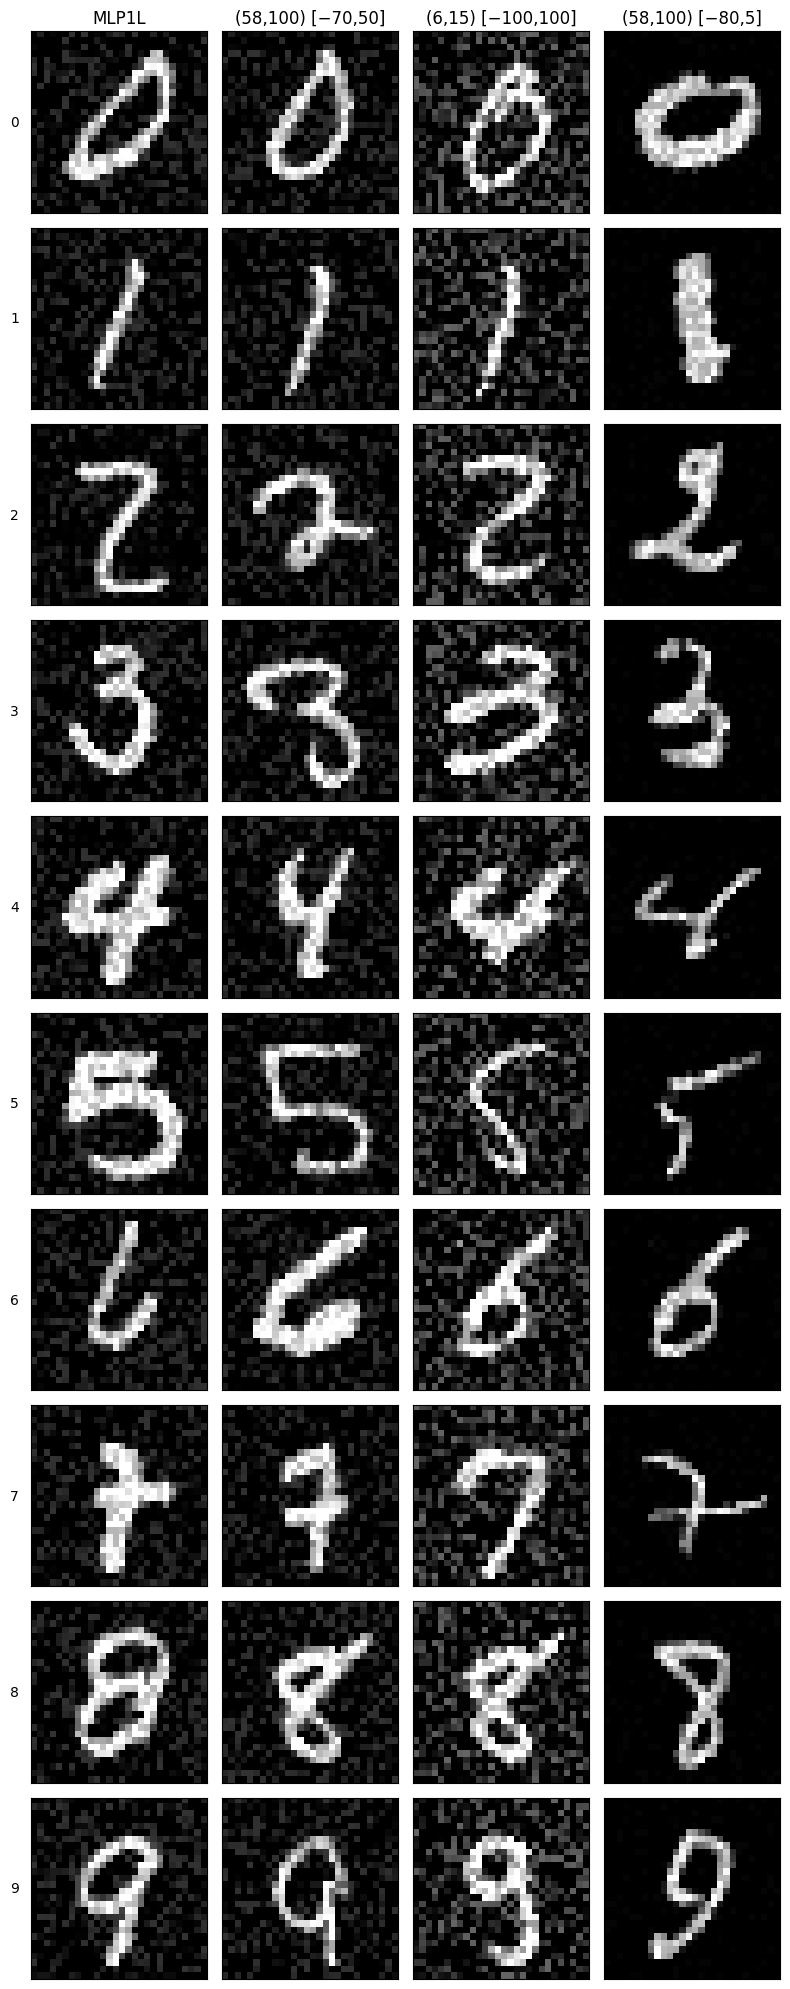

In [25]:
import os
import random
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from collections import defaultdict

def collect_adversarial_samples(folder_path):
    """
    Scan folder_path (expected to be an 'Adversarial' subfolder) for filenames like
      '7_t0_p7_m1046.88.png'
    and return a dict:
      { true_label: [ (full_path, pred_label, magnitude), … ], … }
    """
    exts = ('.png', '.jpg', '.jpeg', '.bmp', '.gif')
    samples = defaultdict(list)

    if not os.path.isdir(folder_path):
        print(f"Warning: folder not found: {folder_path}")
        return samples

    for fname in os.listdir(folder_path):
        base, ext = os.path.splitext(fname)
        if ext.lower() not in exts:
            continue

        parts = base.split('_')
        # Expect e.g. [ “7”, “t0”, “p7”, “m1046.88” ]
        if len(parts) < 4 or not parts[1].startswith('t') \
                        or not parts[2].startswith('p') \
                        or not parts[3].startswith('m'):
            continue

        try:
            true_label = int(parts[1][1:])
            pred_label = int(parts[2][1:])
            magnitude  = float(parts[3][1:])
        except ValueError:
            continue

        samples[true_label].append((
            os.path.join(folder_path, fname),
            pred_label,
            magnitude
        ))

    return samples

def display_adversarial_comparison(base_folders, labels=None, output_filename='ablation_comparison.png'):
    """
    base_folders: list of paths to your four main folders
    labels: optional list of names for each column
    """
    if labels is None:
        labels = [os.path.basename(p) for p in base_folders]

    # For each method: load its “Adversarial” subfolder
    all_samples = [
        collect_adversarial_samples(os.path.join(folder, 'Adversarial'))
        for folder in base_folders
    ]

    n_rows = 10     # digits 0–9
    n_cols = len(base_folders)

    fig, axes = plt.subplots(n_rows, n_cols,
                             figsize=(2*n_cols, 2*n_rows),
                             squeeze=False)

    for col in range(n_cols):
        samples = all_samples[col]
        for digit in range(n_rows):
            ax = axes[digit][col]
            entries = samples.get(digit, [])
            if entries:
                path, pred, mag = random.choice(entries)
                try:
                    img = Image.open(path).resize((28, 28))
                    ax.imshow(np.array(img), cmap='gray', aspect='auto')
                except Exception:
                    ax.text(0.5, 0.5, 'ERR', ha='center', va='center')
                # annotate
                #ax.text(0.02, 0.98, f'{digit} → {pred}',
                #        transform=ax.transAxes,
                #        fontsize=12, ha='left', va='top',
                #        bbox=dict(facecolor='white', alpha=0.7, pad=1))
                #ax.text(0.02, 0.02, f'ε={mag:.2f}',
                #        transform=ax.transAxes,
                #        fontsize=12, ha='left', va='bottom',
                #        bbox=dict(facecolor='white', alpha=0.7, pad=1))
            else:
                ax.text(0.5, 0.5, '—', ha='center', va='center')

            ax.set_xticks([])
            ax.set_yticks([])

            # only label the leftmost column with the true digit
            if col == 0:
                ax.set_ylabel(str(digit),
                              fontsize=10, rotation=0,
                              labelpad=12, va='center')

        # set column title
        axes[0][col].set_title(labels[col], fontsize=12)

    plt.tight_layout()
    plt.savefig(output_filename, dpi=300, bbox_inches='tight')
    print(f"Saved adversarial comparison grid to '{output_filename}'")
    plt.show()


if __name__ == '__main__':
    base = r"C:\Users\dyari\OneDrive\Desktop\batch_CSA\Generated Data"
    folders = [
        os.path.join(base, "unseen_ZC-CSA_images"),
        os.path.join(base, "cnn_ZC-CSA_images"),
        os.path.join(base, "LQ-cnn_ZC-CSA_images"),
        os.path.join(base, "LM-cnn_ZC-CSA_images"),
    ]
    names = ["MLP1L", "(58,100) [−70,50]", "(6,15) [−100,100]", "(58,100) [−80,5]"]

    display_adversarial_comparison(folders, labels=names,
                                   output_filename=r'Generated Data\Cross-Config_comparison.png')
